In [ ]:
pip install pulp

#Import Libraries


In [ ]:
import random as r
import math as m
import pulp as p
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

In [ ]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from google.colab import drive
from oauth2client.client import GoogleCredentials

#Authentication for Google Drive - (COLAB)

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drives = GoogleDrive(gauth)

#load dwnloaded csv for cities in Spain
https://simplemaps.com/data/es-cities


In [ ]:
downloaded = drives.CreateFile({'id':"file_id"})
downloaded.GetContentFile('es.csv')

# Objective Function


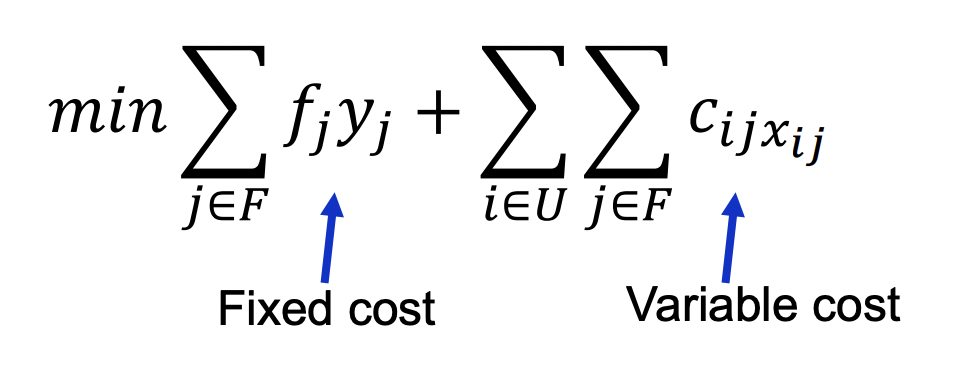

#Constraints
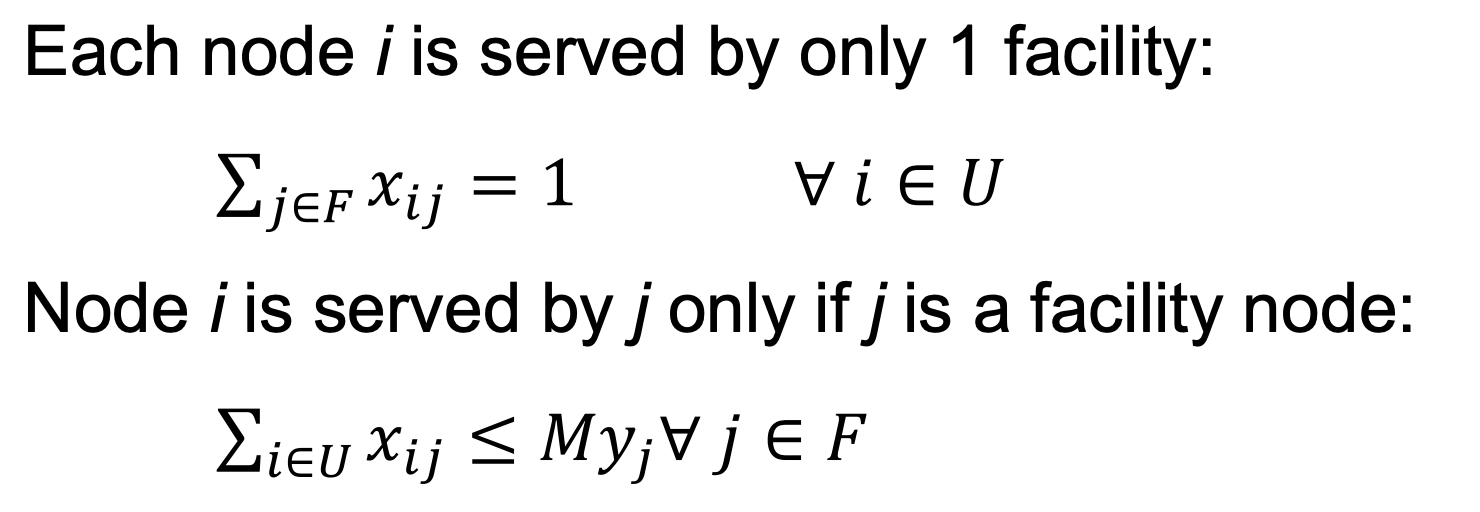

In [ ]:
def locate(f,c):
    n_c=len(c)
    n_f=len(f)
    xf=[0]*n_f
    yf=[0]*n_f
    for j in range(n_f):
        xf[j]=lng[j]
        yf[j]=lat[j]
    plt.plot(xf,yf,'v',color='green')

    return [xf,yf]

#Function used to graphically display a solution
def showsol(f,c,sol,pnt):
    # print(pnt)
    # print(sol)
    # print(f)
    # print(c)
    colors=[]
    for i in range(30):
        colors.append('#%06X'%r.randint(0,0xFFFFFF))
    n_c=len(c)
    n_f=len(f)
    for j in range(n_f):
        if sol[j]:
            #plt.plot(pnt[2][j],pnt[3][j],'v',color=colors[j%(len(colors)-1)],markersize=15)
            plt.plot(pnt[0][j],pnt[1][j],'v',color='red',markersize=15)
        else:
            #plt.plot(pnt[2][j],pnt[3][j],'v',color='blue')
            plt.plot(pnt[0][j],pnt[1][j],'v',color='black', alpha=0.5, markersize=5)
    for i in range(n_c):
        cf=1000000
        el=-1
        for j in range(n_f):
            if sol[j]:
                if cf>c[i][j]:
                    cf=c[i][j]
                    el=j
    plt.show()

In [ ]:
#solve Model
def ilp_model(f,c,pVal):

    n_c=len(c)
    n_f=len(f)

    model=p.LpProblem('P-Median',p.LpMinimize)

    #we create y as the list of decisional binary variables active if we use the corrisponding facility
    y=[0]*n_f
    for j in range(n_f):
        nameV='y'+str(j)
        y[j]=p.LpVariable(name=nameV,cat=p.LpBinary)

    #we create x as the matrix of decisional binary variables
    x=[0]*n_c
    for i in range(n_c):
        x[i]=[0]*n_f
        for j in range(n_f):
            nameV='x'+str(i)+'_'+str(j)
            x[i][j]=p.LpVariable(name=nameV,cat=p.LpBinary)

    #objective function
    obj=p.LpAffineExpression()

    #fixed cost
    for j in range(n_f):
        obj+=f[j]*y[j]

    #transportation cost
    for i in range(n_c):
        for j in range(n_f):
            obj+=c[i][j]*x[i][j]
    model+=obj

    #constraint each customer is served by a single facility
    for i in range(n_c):
        c1=p.LpAffineExpression()
        for j in range(n_f):
            c1+=x[i][j]
        model+=c1==1
   #constraint each facility sould not serve more than 5 million
    for i in range(n_f):
        c2=p.LpAffineExpression()
        for j in range(n_c):
            c2+=x[j][i]*population[i]
        model+=c2<=5000000

    #the customer i is served by only an active facility
    for i in range(n_c):
        for j in range(n_f):
            model+=x[i][j]<=y[j]

    #set the required number of active facilities
    c3=p.LpAffineExpression()
    for j in range(n_f):
        c3+=y[j]
    model+=c3==pVal

    #solve
    status=model.solve()
    print('Status:',p.LpStatus[status])
    obj=p.value(model.objective)
    print('Objective Value:',obj)
    out=[False]*n_f
    for j in range(n_f):
        if p.value(y[j])>0.5:
            out[j]=True
    return out

In [ ]:
# Evaluation Function:
#Function that compute the objective function value for a solution
def evaluate_out(f,c,ris):
    n_c=len(c)
    n_f=len(f)
    cost=0
    # Sum of the activation cost of the facilities used.
    for j in range(n_f):
        if ris[j]:
            cost+=f[j]
    # choose the closest facility for each customer
    for i in range(n_c):
        cf=1000000
        for j in range(n_f):
            if ris[j]:
                if cf>c[i][j]:
                    cf=c[i][j]
        cost+=cf
    return cost

In [ ]:
# Heuristic Method
# Greedy constructive algorithm
def greedy(f, c, pVal):
    n_c = len(c)
    n_f = len(f)
    out = [False] * n_f
    # We activate all the required facilities by always choosing the one that minimizes the objective function
    for k in range(pVal):
        selected = -1
        objSelected = 0
        for j in range(n_f):
            if not out[j]:
                out[j] = True
                obj = evaluate_out(f, c, out)
                out[j] = False
                if selected == -1 or objSelected > obj:
                    selected = j
                    objSelected = obj
        if selected >= 0:
            out[selected] = True
    return out

#Read the CSV file in Pandas

In [ ]:
pip install haversine

Status: Optimal
Objective Value: 64238.66003277196
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, True, False, False, True, True, False, False, False, True, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, False, False, True, False, False, False, False, False, False, False]
{'id': [16, 18, 21, 22, 26, 32, 43, 63, 64, 67], 'City': ['Vitoria-Gasteiz', 'Granada', 'Oviedo', 'Petrel', 'Santa Cruz', 'Leganés', 'Badajoz', 'San Cugat del Vallés', 'Santiago de Compostela', 'El Puerto de Santa María'], 'Population': [253996.0, 233648.0, 219910.0, 218843.0, 209194.0, 191114.0, 150984.0, 92977.0, 92430.0, 88703.0]}
Cost Evaluation of Simple Plant Location: 64238.66003277196
Nodes


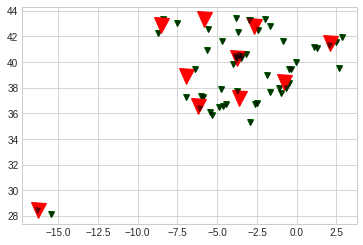

{'id': [16, 17, 18, 25, 26, 37, 59, 63, 64, 66], 'City': ['Vitoria-Gasteiz', 'Elche', 'Granada', 'Jerez de la Frontera', 'Santa Cruz', 'Santander', 'Cáceres', 'San Cugat del Vallés', 'Santiago de Compostela', 'Vaciamadrid'], 'Population': [253996.0, 234765.0, 233648.0, 213105.0, 209194.0, 173375.0, 96255.0, 92977.0, 92430.0, 90973.0]}
[False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, True, True, False, False, False, False, False, False, True, True, False, False, False, False, False, False, False, False, False, False, True, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, True, False, False, False, True, True, False, True, False, False, False, False, False, False, False, False]
Cost Evaluation Greedy: 65260.60961573838


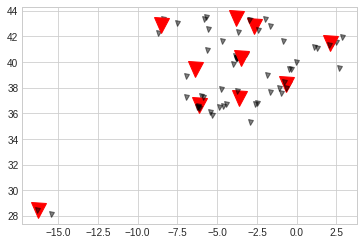

In [ ]:
# Library Calculate the distance between two points on Earth using their latitude and longitude.
import haversine
from haversine import haversine_vector, Unit


#create dataframe
df = pd.read_csv("es.csv")

#limit rows to show on dataframe
limit = 75 #25-50-75
data = df[["city", "lat", "lng", "population"]].head(limit)
city = df["city"].head(limit)
lat =  df["lat"].head(limit)
lng =  df["lng"].head(limit)
population = df["population"].head(limit).tolist()


#len of data
n = len(data)
n_f = n
n_c = n


#consider the cost of each distnace( 1K * 3)
for i in range(n_c):
    for j in range(n_f):
        distances[i, j] = haversine_vector((lat[i], lng[i]), (lat[j], lng[j]),Unit.KILOMETERS)
        transport_cost[i, j] = distances[i, j]*3

#print(transport_cost)
#convert to list
c = transport_cost.tolist()
#fixed cost
facility_cost = [5000]*n_f
f = facility_cost

pVal = 10 #number of facilities to activate

# plot nodes
positions=locate(f,c)
#print(positions)
# simple plant location and plot solution
plant_location=ilp_model(f,c, pVal)

print(plant_location)

#map cities that turned true using the ilp_model to ids
spl_nodes = {"id":[],"City":[],"Population":[]};
for i in range(len(plant_location)):
  if plant_location[i] == True:
    spl_nodes["id"].append(i)
    spl_nodes["City"].append(city[i])
    spl_nodes["Population"].append(population[i])
print(nodes)

print('Cost Evaluation of Simple Plant Location:',evaluate_out(f,c,plant_location))
print("Nodes")
showsol(f,c,plant_location,positions)

# Constructive algorithm and plot solution
const=greedy(f,c,pVal)

#map cities that turned true using the greedy algo
greedy_nodes = {"id":[],"City":[],"Population":[]};
for i in range(len(const)):
  if const[i] == True:
    greedy_nodes["id"].append(i)
    greedy_nodes["City"].append(city[i])
    greedy_nodes["Population"].append(population[i])
print(greedy_nodes)


g_ris=greedy(f,c,pVal)
print(g_ris)

print('Cost Evaluation Greedy:',evaluate_out(f,c,const))

showsol(f,c,const,positions)

In [ ]:
pip install geopandas

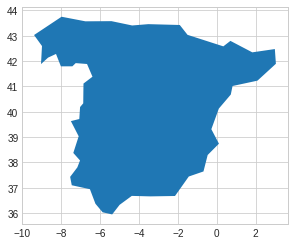

In [ ]:
import matplotlib.pyplot as plt
import geopandas

world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
ax = world[world.name=='Spain'].plot()

plt.show()